In [39]:
import pandas as pd # type: ignore
import numpy as np # type: ignore

# Cargar el dataset de billetes falsos
file_path = "./fake_bills.csv"
df = pd.read_csv(file_path, delimiter=';')

# Mostrar las  filas del dataset para entender su estructura
df


,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
0,True,171.81,104.86,104.95,4.52,2.89,112.83
1,True,171.46,103.36,103.66,3.77,2.99,113.09
2,True,172.69,104.48,103.50,4.40,2.94,113.16
3,True,171.36,103.91,103.94,3.62,3.01,113.51
4,True,171.73,104.28,103.46,4.04,3.48,112.54
...,...,...,...,...,...,...,...
1495,False,171.75,104.38,104.17,4.42,3.09,111.28
1496,False,172.19,104.63,104.44,5.27,3.37,110.97
1497,False,171.80,104.01,104.12,5.51,3.36,111.95
1498,False,172.06,104.28,104.06,5.17,3.46,112.25


In [40]:
# Información general del dataset para detectar valores nulos y tipos de datos
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   is_genuine    1500 non-null   bool   
 1   diagonal      1500 non-null   float64
 2   height_left   1500 non-null   float64
 3   height_right  1500 non-null   float64
 4   margin_low    1463 non-null   float64
 5   margin_up     1500 non-null   float64
 6   length        1500 non-null   float64
dtypes: bool(1), float64(6)
memory usage: 71.9 KB


[ True False]


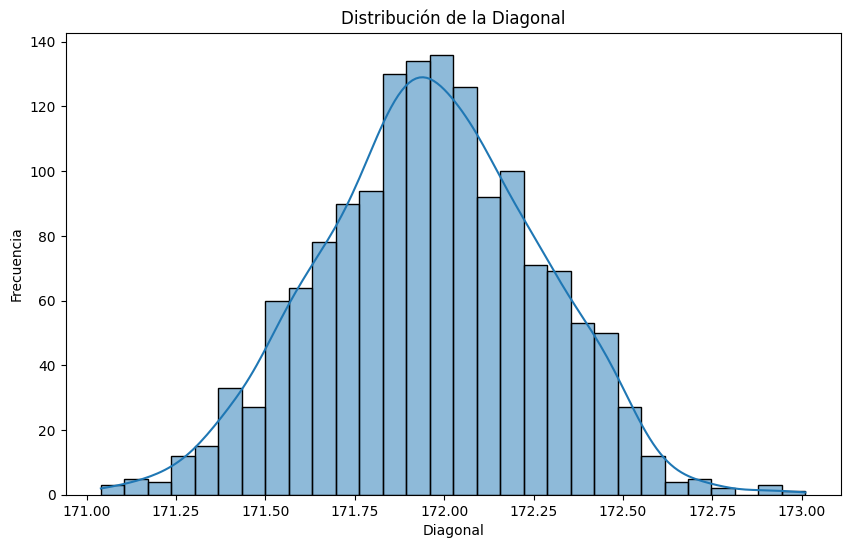

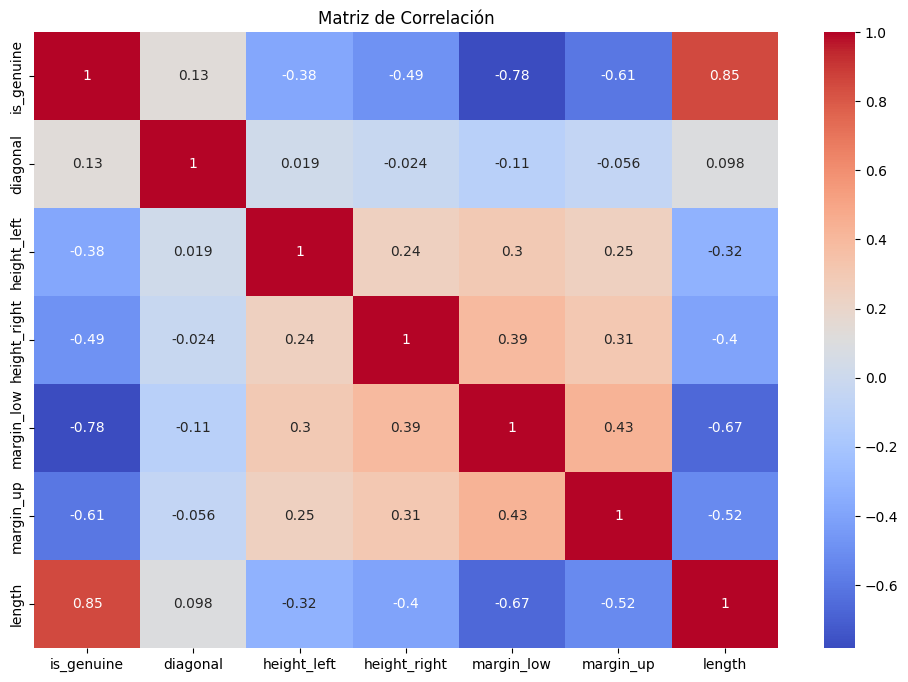

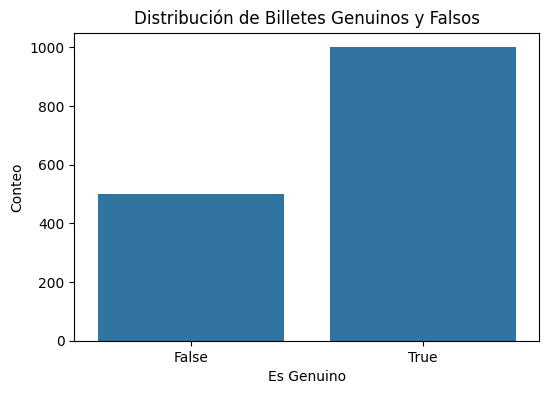

In [41]:
#EDA
import matplotlib.pyplot as plt # type: ignore
import seaborn as sns # type: ignore

# Verificación de valores únicos en la columna 'is_genuine'
print(df['is_genuine'].unique())

# Visualizar la distribución de la característica 'diagonal'
plt.figure(figsize=(10, 6))
sns.histplot(df['diagonal'], bins=30, kde=True)
plt.title('Distribución de la Diagonal')
plt.xlabel('Diagonal')
plt.ylabel('Frecuencia')
plt.show()

# Matriz de correlación para ver la relación entre variables
plt.figure(figsize=(12, 8))
correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Matriz de Correlación')
plt.show()

# Análisis de la distribución de la variable objetivo 'is_genuine'
plt.figure(figsize=(6, 4))
sns.countplot(x='is_genuine', data=df)
plt.title('Distribución de Billetes Genuinos y Falsos')
plt.xlabel('Es Genuino')
plt.ylabel('Conteo')
plt.show()


In [42]:
#Preprocesamiento
from sklearn.preprocessing import StandardScaler, OneHotEncoder # type: ignore
from sklearn.impute import SimpleImputer # type: ignore

# Tratamiento de valores nulos
# Reemplazar valores nulos en características numéricas con la media
imputer = SimpleImputer(strategy='mean')
df[df.columns] = imputer.fit_transform(df[df.columns])

# Escalado de características
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df.drop('is_genuine', axis=1))

# Detectar y manejar valores atípicos (outliers)
Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)
IQR = Q3 - Q1
outliers = ((df < (Q1 - 1.5 * IQR)) | (df > (Q3 + 1.5 * IQR)))
df = df[~outliers.any(axis=1)]
df.head()


,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
1,1.0,171.46,103.36,103.66,3.77,2.99,113.09
2,1.0,172.69,104.48,103.50,4.40,2.94,113.16
3,1.0,171.36,103.91,103.94,3.62,3.01,113.51
4,1.0,171.73,104.28,103.46,4.04,3.48,112.54
5,1.0,172.17,103.74,104.08,4.42,2.95,112.81


In [43]:
from sklearn.model_selection import train_test_split # type: ignore
from sklearn.linear_model import LogisticRegression # type: ignore
from sklearn.tree import DecisionTreeClassifier # type: ignore

# Separar características 'X' y la variable objetivo 'y'
X = df.drop('is_genuine', axis=1)
y = df['is_genuine']

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.7, random_state=42)

# Ajustar el imputer en X_train y transformar tanto X_train como X_test
X_train = imputer.fit_transform(X_train)
X_test = imputer.transform(X_test)

# Inicializar modelos
models = {
    "Regresión Logística": LogisticRegression(),
    "Árboles de Decisión": DecisionTreeClassifier()
}

# Entrenar los modelos
for model_name, model in models.items():
    model.fit(X_train, y_train)


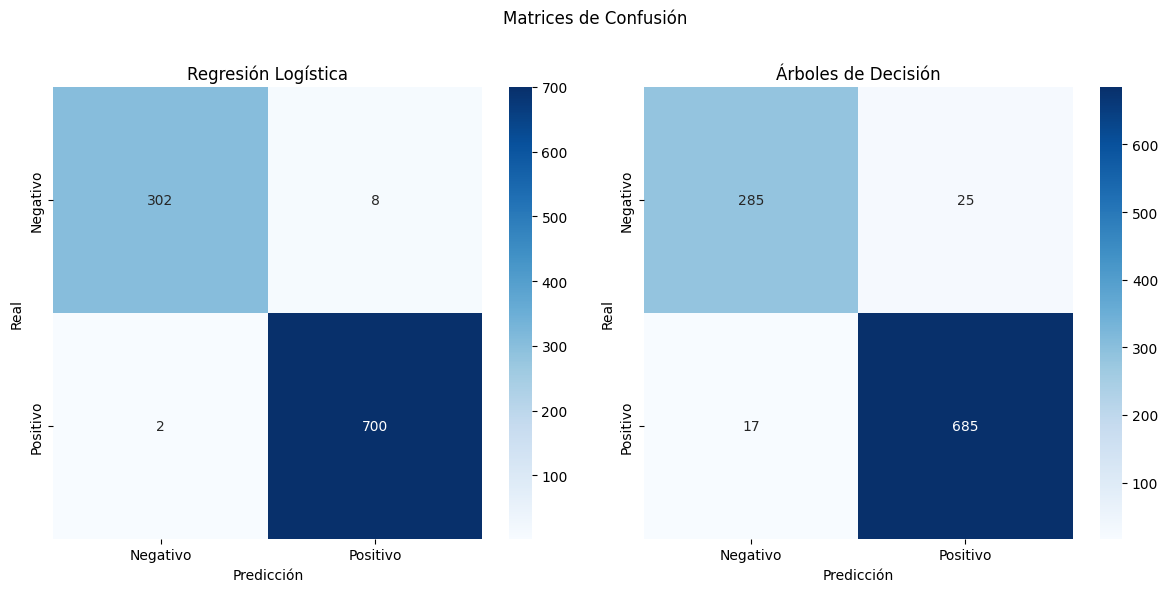

In [44]:
from sklearn.metrics import confusion_matrix # type: ignore

# Gráficas
fig, axes = plt.subplots(1, len(models), figsize=(12, 6))
fig.suptitle('Matrices de Confusión')

# Evaluar modelos
for i, (model_name, model) in enumerate(models.items()):
    # Predecir en el conjunto de prueba
    y_pred = model.predict(X_test)
    
    # Matriz de confusión
    cm = confusion_matrix(y_test, y_pred)
    
    # Graficar la matriz de confusión
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", ax=axes[i])
    axes[i].set_title(f'{model_name}')
    axes[i].set_xlabel('Predicción')
    axes[i].set_ylabel('Real')
    axes[i].set_xticklabels(['Negativo', 'Positivo'])
    axes[i].set_yticklabels(['Negativo', 'Positivo'])

plt.tight_layout()
plt.subplots_adjust(top=0.85)
plt.show()

,precision,recall,f1-score,support
Regresión Logística,,,,
0.0,0.99,0.97,0.98,310.00
1.0,0.99,1.00,0.99,702.00
accuracy,0.99,0.99,0.99,0.99
macro avg,0.99,0.99,0.99,1012.00
weighted avg,0.99,0.99,0.99,1012.00


,precision,recall,f1-score,support
Árboles de Decisión,,,,
0.0,0.94,0.92,0.93,310.00
1.0,0.96,0.98,0.97,702.00
accuracy,0.96,0.96,0.96,0.96
macro avg,0.95,0.95,0.95,1012.00
weighted avg,0.96,0.96,0.96,1012.00


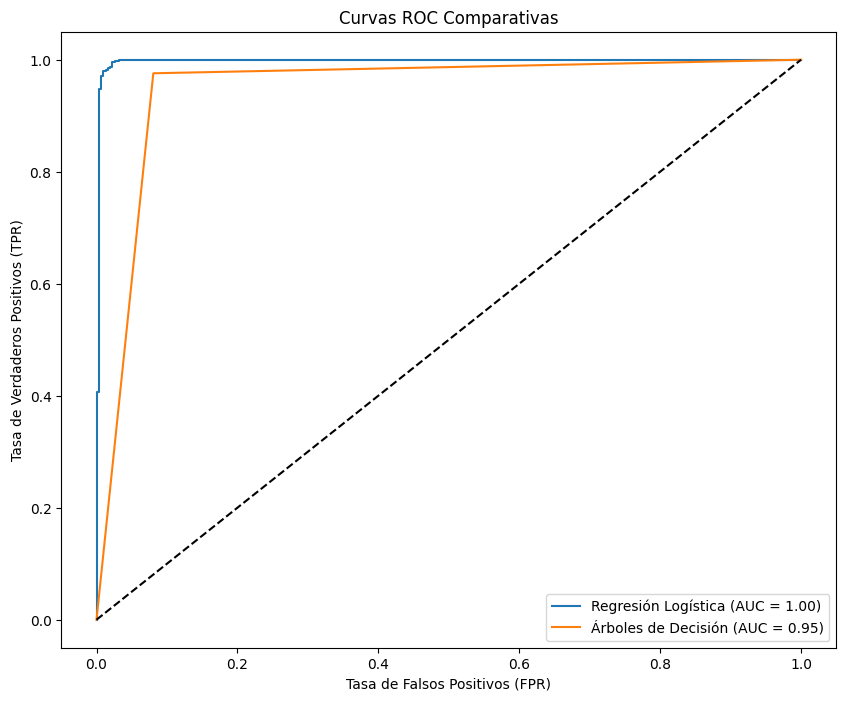

In [45]:
# Reporte de clasificación
from sklearn.metrics import classification_report, roc_curve, roc_auc_score # type: ignore
reports_dict = {}
for model_name, model in models.items():
    y_pred = model.predict(X_test)
    report = classification_report(y_test, y_pred, output_dict=True)
    report_df = pd.DataFrame(report).transpose()
    report_df.index.name = model_name
    reports_dict[model_name] = report_df

for model_name, report_df in reports_dict.items():
    styled_report_df = report_df.style.format("{:.2f}") \
                                      .set_table_styles([
                                          {'selector': 'th', 'props': [('font-size', '14px'), ('text-align', 'center')]},
                                          {'selector': 'td', 'props': [('padding', '8px'), ('text-align', 'center')]},
                                          {'selector': 'caption', 'props': [('caption-side', 'bottom')]}
                                      ]) \
                                      .set_caption(f"Reporte de Clasificación de {model_name}")
    display(styled_report_df)

# Curvas ROC
plt.figure(figsize=(10, 8))
plt.title('Curvas ROC Comparativas')

# Graficar las curvas ROC
for model_name, model in models.items():
    y_prob = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    auc_score = roc_auc_score(y_test, y_prob)
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {auc_score:.2f})')

# Línea de referencia de un modelo aleatorio
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.legend()
plt.show()
